**Import Packages and Load Dataset**

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip

replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
images_path = './Flicker8k_Dataset'
captions_file = './Flickr8k.token.txt'
captions_path = '/content/sample_data/captions.txt'


**Extract Features and define model**

In [4]:
model = VGG16()

In [5]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
features = {}
for img_name in tqdm(os.listdir(images_path)):

    # load the image from file
    img_path = images_path + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))

    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for vgg
    image = preprocess_input(image)

    # extract features
    feature = model.predict(image, verbose=0)

    # get image ID
    image_id = img_name.split('.')[0]

    # store feature
    features[image_id] = feature



  0%|          | 0/8091 [00:00<?, ?it/s]

In [7]:
import pickle
pickle.dump(features, open('./features.pkl', 'wb'))

In [8]:
with open('./features.pkl', 'rb') as f:
    features = pickle.load(f)

**Loading the captions Data**

In [9]:
with open(captions_path, 'r') as f:
    next(f)
    captions_doc = f.read()


In [10]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):

    # split the line by comma(,)
    tokens = line.split(',')

    if len(line) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]

    # remove extension from image ID
    image_id = image_id.split('.')[0]

    # convert caption list to string
    caption = " ".join(caption)

    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

**PreProcessing Data**

In [12]:
def clean(mapping):

    for key, captions in mapping.items():

        for i in range(len(captions)):

            # take one caption at a time
            caption = captions[i]

            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()

            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')

            # delete additional spaces
            caption = caption.replace('\s+', ' ')

            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
# preprocess the text
clean(mapping)

In [15]:
# after preprocess of text
mapping['1000268201_693b08cb0e']



['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

**Tokenize the text**

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size


8485

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

**Load Train and Test Set**

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]


In [22]:
print(len(train))
print(len(test))

7281
810


In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:

            n += 1
            captions = mapping[key]

            # process each caption
            for caption in captions:

                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # split the sequence into X, y pairs
                for i in range(1, len(seq)):

                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

**Building a Model**

In [24]:
# Encoder - Contextual representation

# image feature layers
inputs1 = Input(shape=(4096,))

fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))

se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder - Generates o/p
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

# output
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2172160     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

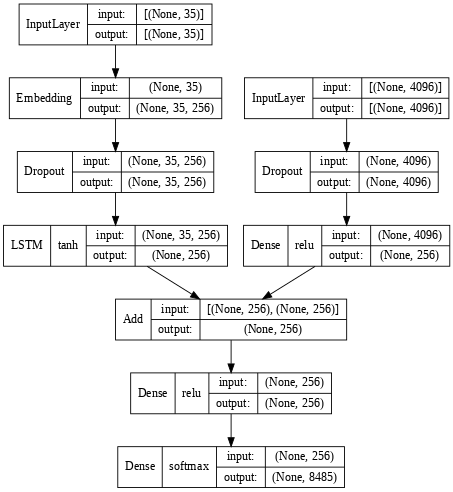

In [25]:
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=64)


In [26]:
from tensorflow import keras
# train the model
epochs = 5
batch_size = 128
steps = len(train)//batch_size

es = keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=4)
for i in range(epochs):

    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[es])

56/56 [==============================] - 50s 889ms/step - loss: 3.6627


In [27]:
model.save('./initial_model.h5')


**Generate Captions**

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):

    # add start tag for generation process
    in_text = 'startseq'

    # iterate over the max length of sequence
    for i in range(max_length):

        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        # pad the sequence
        sequence = pad_sequences([sequence], max_length)

        # predict next word
        yhat = model.predict([image, sequence], verbose=0)

        # get index with high probability
        yhat = np.argmax(yhat)

        # convert index to word
        word = idx_to_word(yhat, tokenizer)

        # stop if word not found
        if word is None:
            break

        # append word as input for generating next word
        in_text += " " + word

        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

**BLEU Score**

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):

    # get actual caption
    captions = mapping[key]

    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # append to the list
    actual.append(actual_captions)

    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU: 0.540107


**Caption Image**

In [31]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):

    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(images_path, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('=============================== Actual ===============================')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('      ')
    print('============================== Predicted ==============================')
    print(y_pred)
    plt.imshow(image)

=============================== Actual ===============================
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
      
============================== Predicted ==============================
startseq man and boy and kayak are kayak in water endseq


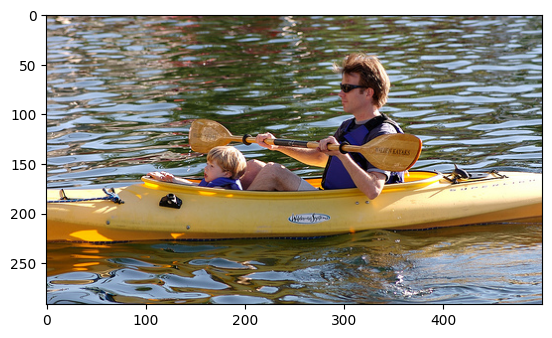

In [34]:
generate_caption("1028205764_7e8df9a2ea.jpg")

=============================== Actual ===============================
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
      
============================== Predicted ==============================
startseq man in red jacket is skiing down the snow endseq


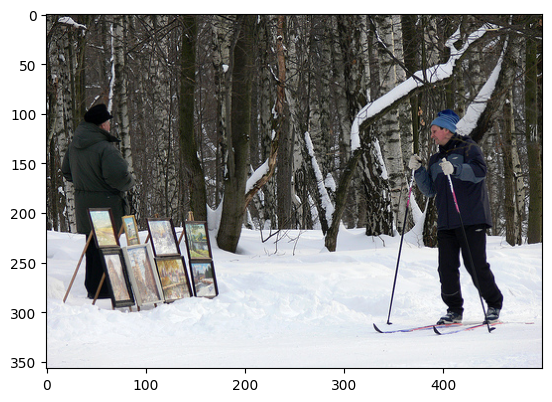

In [36]:
generate_caption("101669240_b2d3e7f17b.jpg")

=============================== Actual ===============================
startseq dog prepares to catch thrown object in field with nearby cars endseq
startseq white dog is about to catch yellow ball in its mouth endseq
startseq white dog is about to catch yellow dog toy endseq
startseq white dog is ready to catch yellow ball flying through the air endseq
startseq white dog running after yellow ball endseq
      
============================== Predicted ==============================
startseq white dog is running through the grass endseq


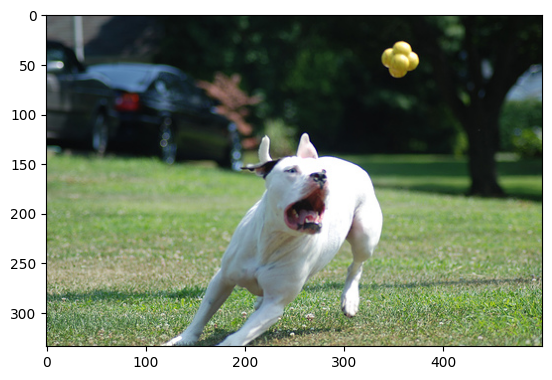

In [37]:
generate_caption("1019604187_d087bf9a5f.jpg")